## Implement linear regression as a tf.estimator

We will go over the code of the linear regression model again.

Then we will build the linear regression code as explained in 
- https://www.tensorflow.org/api_docs/python/tf/estimator/Estimator


### Modules

- **`export`** module: Utility methods for exporting Estimator.
- **`inputs`** module: Utility methods to create simple input_fns.

### Relevant Classes for this notebook

- class **`Estimator`**: Estimator class to train and evaluate TensorFlow models.
- class **`RunConfig`** : This class specifies the configurations for an Estimator run

### Other classes
- class **`EstimatorSpec`** : Ops and objects returned from a model_fn and passed to Estimator.
- class **`ModeKeys`** : Standard names for model modes.



In [12]:
import tensorflow as tf
from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib

import numpy as np
import matplotlib
from matplotlib  import pyplot as plt
import pprint

%matplotlib inline
np.__version__, tf.__version__

('1.13.0', '1.2.0')

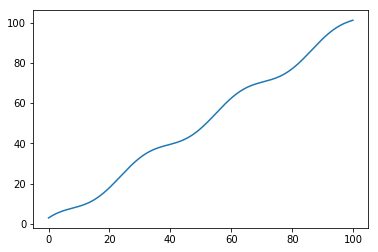

In [13]:
x = np.arange(100, step=0.1)
y = x + 3 * np.cos(x/5)  
plt.plot(x, y)

In [14]:
n_samples = 1000
batch_size = 10

# rewrite as column vector
x = np.reshape(x, (n_samples, 1))
y = np.reshape(y, (n_samples, 1)) 

## About a tf.contrib.learn.Estimator 

- **`class tf.contrib.learn.BaseEstimator`**
    - Abstract BaseEstimator class to train and evaluate TensorFlow models. We will use BaseEstimator by defining Estimator objects which initialize a BaseEstimator instance.



The **`tf.contrib.learn.Estimator`** object is the standard way to wrap a model in Tensorflow. 
In order to build an **`Estimator`** we need to specify:

```python
tf.contrib.learn.Estimator.__init__( model_fn=None,
                                     model_dir=None,
                                     config=None,
                                     params=None,
                                     feature_engineering_fn=None)
```

#### Overview of the parts 

- **`model_fn`** is a function that returns a `ModelFnOps` object which contains the information of the ops necesary to perform trainig, evaluation or predictions. 
   - Arguments of  `model_fn` function:
      - **`features`**: **single Tensor or dict of Tensors** (depending on data passed to fit),
      - **`labels`**: **Tensor or dict of Tensors **(for multi-head models). If mode is ModeKeys.INFER, labels=None will be passed. If the model_fn's signature does not accept mode, the model_fn must still be able to handle labels=None.
      - **`mode`**: **Optional**. Specifies if this training, evaluation or prediction. See ModeKeys.
      - **`params`**: **Optional** dict of hyperparameters. Will receive what is passed to Estimator in params parameter. This allows to configure Estimators from hyper parameter tuning.
      - **`config`**: **Optional** configuration object. Will receive what is passed to Estimator in config parameter, or the default config. Allows updating things in your model_fn based on configuration such as num_ps_replicas.
      - **`model_dir`**: **Optional** directory where model parameters, graph etc are saved. Will receive what is passed to Estimator in model_dir parameter, or the default model_dir. Allows updating things in your model_fn that expect model_dir, such as training hooks.
      
- **`model_dir`**: Directory to save model parameters, graph etc. This can also be used to load checkpoints from the directory into a estimator to continue training a previously saved model.

- **`config`**: Configuration object

- **`params`**: dictionary of hyper parameters that will be passed into model_fn. Keys are names of parameters, values are basic python types.

- **`feature_engineering_fn`** : Feature engineering function. Takes features and labels which are the output of input_fn and returns features and labels which will be fed into model_fn. Please check model_fn for a definition of features and labels.

Supports next three signatures for the function:

    (features, labels) -> (predictions, loss, train_op)
    (features, labels, mode) -> (predictions, loss, train_op)
    (features, labels, mode, params) -> (predictions, loss, train_op)
    (features, labels, mode, params, config) -> (predictions, loss, train_op)
    (features, labels, mode, params, config, model_dir) -> (predictions, loss, train_op)




In [15]:
estimator = tf.contrib.learn.Estimator()

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f2f0359a0f0>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/tmplmumtn67'}


In [16]:
help(estimator.fit)

Help on method fit in module tensorflow.contrib.learn.python.learn.estimators.estimator:

fit(x=None, y=None, input_fn=None, steps=None, batch_size=None, monitors=None, max_steps=None) method of tensorflow.contrib.learn.python.learn.estimators.estimator.Estimator instance
    See `Trainable`. (deprecated arguments)
    
    SOME ARGUMENTS ARE DEPRECATED. They will be removed after 2016-12-01.
    Instructions for updating:
    Estimator is decoupled from Scikit Learn interface by moving into
    separate class SKCompat. Arguments x, y and batch_size are only
    available in the SKCompat class, Estimator will only accept input_fn.
    Example conversion:
      est = Estimator(...) -> est = SKCompat(Estimator(...))
    
    Raises:
      ValueError: If `x` or `y` are not `None` while `input_fn` is not `None`.
      ValueError: If both `steps` and `max_steps` are not `None`.



## Defining the graph for the linear regressor

In [17]:
x.shape

(1000, 1)

In [18]:
c = np.array([[3.,4], [5.,6], [6.,7]])
print(np.mean(c,1))

[ 3.5  5.5  6.5]


In [20]:
tf.reset_default_graph()
batch_size_ = 50
n_features_ = 1
linear_regression_graph = tf.Graph()
seed_val = 123

with linear_regression_graph.as_default():
    batch_size = batch_size_
    n_features = n_features_

    pl_x = tf.placeholder(name="pl_x", dtype=tf.float32, shape=(None, 1))
    pl_y = tf.placeholder(name="pl_y", dtype=tf.float32, shape=(None, 1))
    W = tf.get_variable("weights", (1, 1), initializer=tf.random_normal_initializer(seed=seed_val))
    b = tf.get_variable("bias", (1, ), initializer=tf.constant_initializer(0.))
    y_pred = tf.matmul(pl_x, W) + b    
    loss = tf.reduce_mean(((pl_y - y_pred)**2))/x.shape[0]
    #loss = tf.reduce_sum(tf.pow(y_pred - pl_y, 2))/x.shape[0]
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss)
    
    # Add allways the  tf.global_variables_initializer() and tf.Saver() in the graph
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    #saver.save(as_default, "./saved_tests/linear_regression_saver.ckpt")
    pprint.pprint(tf.global_variables())


[<tf.Variable 'weights:0' shape=(1, 1) dtype=float32_ref>,
 <tf.Variable 'bias:0' shape=(1,) dtype=float32_ref>]


In [21]:
linear_regression_graph

In [22]:
tf.__version__

'1.2.0'

In [23]:
def update_model(features=x, labels = y):
    return optimizer

linear_regressor = tf.estimator.Estimator(update_model)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpz6cdfupf', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000}


In [24]:
linear_regressor

In [25]:
help(linear_regressor.train)

Help on method train in module tensorflow.python.estimator.estimator:

train(input_fn, hooks=None, steps=None, max_steps=None) method of tensorflow.python.estimator.estimator.Estimator instance
    Trains a model given training data input_fn.
    
    Args:
      input_fn: Input function returning a tuple of:
          features - `Tensor` or dictionary of string feature name to `Tensor`.
          labels - `Tensor` or dictionary of `Tensor` with labels.
      hooks: List of `SessionRunHook` subclass instances. Used for callbacks
        inside the training loop.
      steps: Number of steps for which to train model. If `None`, train forever
        or train until input_fn generates the `OutOfRange` or `StopIteration`
        error. 'steps' works incrementally. If you call two times
        train(steps=10) then training occurs in total 20 steps. If `OutOfRange`
        or `StopIteration` error occurs in the middle, training stops before 20
        steps. If you don't want to have increm

In [26]:
help(linear_regressor.evaluate)

Help on method evaluate in module tensorflow.python.estimator.estimator:

evaluate(input_fn, steps=None, hooks=None, checkpoint_path=None, name=None) method of tensorflow.python.estimator.estimator.Estimator instance
    Evaluates the model given evaluation data input_fn.
    
    For each step, calls `input_fn`, which returns one batch of data.
    Evaluates until:
    - `steps` batches are processed, or
    - `input_fn` raises an end-of-input exception (`OutOfRangeError` or
    `StopIteration`).
    
    Args:
      input_fn: Input function returning a tuple of:
          features - Dictionary of string feature name to `Tensor` or
            `SparseTensor`.
          labels - `Tensor` or dictionary of `Tensor` with labels.
      steps: Number of steps for which to evaluate model. If `None`, evaluates
        until `input_fn` raises an end-of-input exception.
      hooks: List of `SessionRunHook` subclass instances. Used for callbacks
        inside the evaluation call.
      checkpo

## About learn module in tensorflow

- http://terrytangyuan.github.io/2016/06/09/scikit-flow-v09/


BaseEstimator is the abstract and base class for training and evaluating TensorFlow models. It provides the basic functionalities like `fit()`, `partial_fit()`, `evaluate()`, and `predict()` by utilizing detailed logics hidden in `graph_actions.py`.

In [30]:
#### Using learnºº
from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib

In [33]:
help(model_fn_lib.ModelFnOps)

Help on class ModelFnOps in module tensorflow.contrib.learn.python.learn.estimators.model_fn:

class ModelFnOps(ModelFnOps)
 |  Ops returned from a model_fn.
 |  
 |  Method resolution order:
 |      ModelFnOps
 |      ModelFnOps
 |      builtins.tuple
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  estimator_spec(self, default_serving_output_alternative_key=None)
 |      Creates an equivalent `EstimatorSpec`.
 |      
 |      Args:
 |        default_serving_output_alternative_key: Required for multiple heads. If
 |          you have multiple entries in `output_alternatives` dict (comparable to
 |          multiple heads), `EstimatorSpec` requires a default head that will be
 |          used if a Servo request does not explicitly mention which head to infer
 |          on. Pass the key of the output alternative here that you want to
 |          designate as default. A separate ExportOutpout for this default head
 |          wil be added to the export_outputs dict with t

In [29]:
def model_fn(features, labels, mode):
    
    model_fn_lib.ModelFnOps(mode=mode,
                            predictions=predictions,
                            loss=loss,
                            train_op=train_op)

### Saving a session with saver = tf.train.Saver()

In [ ]:
with tf.Session(graph=linear_regression_graph) as sess:
    sess.run(tf.global_variables_initializer())   # equivalently sess.run(init)
    print("\nParameters before learning")
    print("weights before training: ",sess.run([W]))
    print("bias before training: ",sess.run([b]))
    y_hat = sess.run(y_pred, feed_dict={pl_x:x})

plt.title("Solution of the linear regressor BEFORE training", color="red")
plt.plot(x, y_hat, color="red")
plt.plot(x, y,"blue")

In [ ]:
n_epochs = 80
batch_size = 50
indices_batches = [ x for x in range(0, len(x) + 1, batch_size) ]
print_every_k = 10

with tf.Session(graph=linear_regression_graph) as sess:
    sess.run(tf.global_variables_initializer())
    print("\nParameters before learning")
    print("weights before trainin: ",sess.run([W]))
    print("bias before trainin: ",sess.run([b]))
    print("")

    for epoch in range(n_epochs):
        mean_loss = []
        for b_beg, b_end in zip(indices_batches[0:-1], indices_batches[1:]):
            _, l = sess.run([optimizer, loss], feed_dict={pl_x: x[b_beg:b_end], 
                                                          pl_y: y[b_beg:b_end]})
            mean_loss.append(l)
        if epoch % print_every_k+1 ==1:
            print("epoch: ", epoch, " loss: ", np.mean(mean_loss))
        #writer = tf.summary.FileWriter('./my_graph/linear_reg', sess.graph)
    #saver.save(sess, "./saved_tests/linear_regression.cpkt")
    
    #saver.export_meta_graph("./saved_tests/linear_regression_saver.meta")
    print("\nParameters after learning")
    print("weights after training: ",sess.run([W]))
    print("bias after training: ",sess.run([b]))

    ### This saves the graph in a file so we can load it later on
    #saver.save(sess, "./saved_tests/linear_regression.cpkt")
    saver.save(sess, "./saved_tests/linear_regression_saver2.ckpt")
    
    tf.train.export_meta_graph("./saved_tests/linear_regression.cpkt")
    #tf.train.export_meta_graph("./saved_tests/linear_regression.cpkt")


In [ ]:
with tf.Session(graph=linear_regression_graph) as sess:
    saver.restore(sess,"./saved_tests/linear_regression_saver2.ckpt") 
    print("\nParameters after learning")
    print("weights before training: ",sess.run([W]))
    print("bias before training: ",sess.run([b]))
    y_hat = sess.run(y_pred, feed_dict={pl_x:x})

plt.title("Solution of the linear regressor AFTER training", color="red")
plt.plot(x, y_hat, color="red")
plt.plot(x, y,"blue")

### Retraining in a new session using a past saved session

In [ ]:
tf.reset_default_graph()
batch_size_ = 10
n_features_ = 1
linear_regression_graph = tf.Graph()
seed_val = 123

with linear_regression_graph.as_default():
    batch_size = batch_size_
    n_features = n_features_

    pl_x = tf.placeholder(name="pl_x", dtype=tf.float32, shape=(None, 1))
    pl_y = tf.placeholder(name="pl_y", dtype=tf.float32, shape=(None, 1))
    W = tf.get_variable("weights", (1,1), initializer=tf.random_normal_initializer(seed=seed_val))
    b = tf.get_variable("bias", (1,), initializer=tf.constant_initializer(0.))
    y_pred = tf.matmul(pl_x, W) + b    
    loss = tf.reduce_mean((pl_y - y_pred)**2/batch_size)
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss)
    
    # Add allways the  tf.global_variables_initializer() and tf.Saver() in the graph
    init = tf.global_variables_initializer()   
    saver = tf.train.Saver()
    #saver.save(as_default, "./saved_tests/linear_regression_saver.ckpt")
    pprint.pprint(tf.global_variables())


In [ ]:
tf.reset_default_graph()
batch_size = 80
n_epochs = 50
indices_batches = [ x for x in range(0, len(x) + 1, batch_size) ]

with tf.Session(graph=linear_regression_graph) as sess:
    saver.restore(sess,"./saved_tests/linear_regression_saver2.ckpt") 
    #saver.import_meta_graph("./saved_tests/linear_regression_saver.meta")
    print("\n\nShow me W and b")
    print("weights after training: ",sess.run([W]))
    print("bias after training: ",sess.run([b]), "\n")
    
    for epoch in range(n_epochs):
        mean_loss = []
        for b_beg, b_end in zip(indices_batches[0:-1], indices_batches[1:]):
            _, l = sess.run([optimizer, loss], feed_dict={pl_x: x[b_beg:b_end], 
                                                          pl_y: y[b_beg:b_end]})
            mean_loss.append(l)
        print("epoch: ", epoch, " loss: ", np.mean(mean_loss))


In [ ]:
#with tf.gfile.FastGFile("./saved_tests/linear_regression.cpkt") as f:
#    graph_def = tf.GraphDef()
#    graph_def.ParseFromString(f.read())
#    _ = tf.import_graph_def(graph_def, name="")

### Export a MetaGraph

A MetaGraph contains both a TensorFlow GraphDef as well as associated metadata necessary for running computation in a graph when crossing a process boundary. It can also be used for long term storage of graphs.

The MetaGraph contains the information required to continue training, perform evaluation, or run inference on a previously trained graph.

The APIs for exporting and importing the complete model are in the ``tf.train.Saver`` class: ``tf.train.export_meta_graph`` and ``tf.train.import_meta_graph``.

#### Inside a metagraph

The information contained in a MetaGraph is expressed as a MetaGraphDef protocol buffer. It contains the following fields:

- **MetaInfoDef** for meta information, such as version and other user information.

- **GraphDef** for describing the graph.

- **SaverDef** for the saver.

- **CollectionDef** map that further describes additional components of the model, such as ``Variables``, ``tf.train.QueueRunner``, etc. In order for a Python object to be serialized to and from MetaGraphDef, the Python class must implement ``to_proto()`` and ``from_proto()`` methods, and register them with the system using register_proto_function.


## About a tf.estimator.Estimator (not used in the notebook)


- http://terrytangyuan.github.io/2016/07/08/understand-and-build-tensorflow-estimator/

- http://blog.mdda.net/ai/2017/02/25/estimator-input-fn

- https://www.youtube.com/watch?v=5DknTFbcGVM&t=8s&list=PLOU2XLYxmsIKC8eODk_RNCWv3fBcLvMMy&index=47

The source code is in `tensorflow/python/estimator/estimator.py`.

The **`Estimator`** object is the standard way to wrap a model in Tensorflow. 
In order to build an **`Estimator`** we need to specify:

-  **`train_op`** 
-  **`eval_op`**
-  **`predictions`**

#### Overview of the parts 

- **`model_fn`** must return the ops necesary to perform trainig, evaluation or predictions.

